In [1]:
# In this script we will be loading our datasets and fine-tuning the mobilenetV2 model

# Importing required packages

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input

from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import os

Using TensorFlow backend.


In [2]:
# loading dataset from disk

print("[INFO] Loading image dataset from disk...")
imagePaths = list(paths.list_images("D:/adity/Projects/face_mask_detection/dataset"))
print("\n[INFO] Number of Images found: {}".format(len(imagePaths)))

[INFO] Loading image dataset from disk...

[INFO] Number of Images found: 1376


In [3]:
# Since we are low on dataset we will be using mobilenetV2 as our basemodel and train the headmodel that we will attach to it

# Inintializing empty list of data and labels
data = []
labels = []

# lets loop over our images
print("[INFO] Looping over our images to gather labels...")
for imagePath in imagePaths:
    
    # lets grab labels of each image
    label = imagePath.split(os.path.sep)[-2]
    
    # loading image and preprocessing it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # appending them to data and labels
    data.append(image)
    labels.append(label)
    
print("[INFO] data: {}".format(len(data)))
print("[INFO] labels: {}".format(len(labels)))

# converting data and labels to numpy_array
data = np.array(data, dtype="float32")
labels = np.array(labels)
#len(set(labels))

[INFO] Looping over our images to gather labels...
[INFO] data: 1376
[INFO] labels: 1376


In [4]:
# performing one_hot encoding on labels

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partioning my dataset
print("[INFO] Partitioning dataset...")
(trainX, TestX, trainY, TestY) = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
(valX, testX, valY, testY) = train_test_split(TestX, TestY, test_size=0.5, stratify=TestY, random_state=2)

print("[INFO] train_dataX: {}\n[INFO] train_dataY: {}\n[INFO] val_dataX: {}\n[INFO] val_dataY: {}\n[INFO] test_dataX: {}\n[INFO] test_dataY: {}".format(len(trainX), len(trainY), len(valX), len(valY), len(testX), len(testY)))

[INFO] Partitioning dataset...
[INFO] train_dataX: 963
[INFO] train_dataY: 963
[INFO] val_dataX: 206
[INFO] val_dataY: 206
[INFO] test_dataX: 207
[INFO] test_dataY: 207


In [5]:
# constructing training image generator for data augmentation

print("[INFO] Constructing Image Generator for Augmentation...")
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

[INFO] Constructing Image Generator for Augmentation...


In [6]:
# now lets fine-tune MObileNetV2 model

print("[INFO] Fine-Tuning Model begins...")

# loading the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# lets construct our own head to place at the top of our base_model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)

# appending FC layer
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(units=128, activation="relu")(headModel)
headModel = Dropout(rate=0.5)(headModel)

# softmax-classifier
headModel = Dense(units=2, activation="softmax")(headModel)

# lets place the headModel on top of baseModel which will become our actual model
model = Model(inputs=baseModel.input, outputs=headModel)

# lets freeze the layers of baseModel to avoid updating them in first training process
for layer in baseModel.layers:
    layer.trainable = False
    
print("\n[INFO] Fine-Tuning Model accomplished...")

[INFO] Fine-Tuning Model begins...


C:\Users\adity\.conda\envs\tf-gpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



[INFO] Fine-Tuning Model accomplished...


In [7]:
# Initializing parameters

lr = 1e-4
epochs = 200
batch_size = 20

In [8]:
# lets compile our model and initialize optimizer and early-stopping

print("[INFO] Compiling Model...")

opt = Adam(lr=lr, decay=lr/epochs)
es = EarlyStopping(monitor="val_loss", patience=25, mode="min", restore_best_weights=True)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] Compiling Model...


In [9]:
# lets look at our model structure
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [10]:
# lets begin training our network head
print("[INFO] Training Head for: {} epochs...".format(epochs))
res = model.fit(aug.flow(trainX, trainY, batch_size=batch_size), callbacks=[es], steps_per_epoch=len(trainX)/batch_size, validation_data=(valX, valY), validation_steps=len(valX)/batch_size, epochs=epochs)

[INFO] Training Head for: 200 epochs...
Epoch 1/200
49/48 [==============================] - 25s 509ms/step - loss: 0.6249 - accuracy: 0.6739 - val_loss: 0.3564 - val_accuracy: 0.8932
Epoch 2/200
49/48 [==============================] - 11s 223ms/step - loss: 0.3502 - accuracy: 0.8463 - val_loss: 0.1934 - val_accuracy: 0.9757
Epoch 3/200
49/48 [==============================] - 12s 238ms/step - loss: 0.2681 - accuracy: 0.9065 - val_loss: 0.1349 - val_accuracy: 0.9709
Epoch 4/200
49/48 [==============================] - 12s 238ms/step - loss: 0.2418 - accuracy: 0.9232 - val_loss: 0.0935 - val_accuracy: 0.9806
Epoch 5/200
49/48 [==============================] - 12s 239ms/step - loss: 0.1856 - accuracy: 0.9315 - val_loss: 0.0752 - val_accuracy: 0.9854
Epoch 6/200
49/48 [==============================] - 11s 233ms/step - loss: 0.2069 - accuracy: 0.9190 - val_loss: 0.0620 - val_accuracy: 0.9806
Epoch 7/200
49/48 [==============================] - 11s 230ms/step - loss: 0.1760 - accuracy: 0

In [12]:
# lets evaluate the network

print("[INFO] Evaluating the Network...")
predictionsIdxs = model.predict(testX, batch_size=batch_size)

# we have to find the index for the label with highest prediction value
predictionsIdxs = np.argmax(predictionsIdxs, axis=1)

# lets have a look at classification report
print(classification_report(testY.argmax(axis=1), predictionsIdxs, target_names=lb.classes_))

[INFO] Evaluating the Network...
              precision    recall  f1-score   support

   with_mask       1.00      0.97      0.99       104
without_mask       0.97      1.00      0.99       103

    accuracy                           0.99       207
   macro avg       0.99      0.99      0.99       207
weighted avg       0.99      0.99      0.99       207



In [20]:
# lets serialize the model to disk

print("[INFO] Saving Mask_Detector Model to disk...")
model.save("mask_detector.model")

[INFO] Saving Mask_Detector Model to disk...


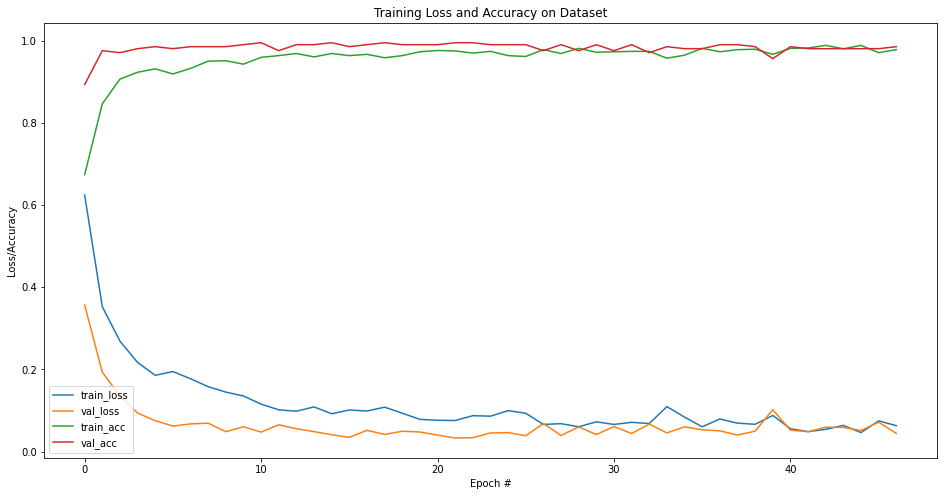

In [18]:
# lets plot a graph to visualize our networks performance

plt.figure(figsize=(16,8))

plt.plot(np.arange(0, 47), res.history["loss"], label="train_loss")
plt.plot(np.arange(0, 47), res.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 47), res.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 47), res.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()